# CNN Training Section
In this section we train Resnet34 on histological colorectal tissue images in order to classify it into 8 classifications
Code referenced as being from the skin lesion project was sourced from the follwing: https://github.com/IFL-CAMP/SLClassificationAnEducationalCode-MEC2019

In [1]:
# All of the imports that we are going to use for this projet
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#Instructing Pytorch to use the GPU if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [61]:
import shutil
import pathlib

# Image directory names. Images can be downloaded at: https://zenodo.org/record/53169#.XrclTqhKhjH
source = "Kather_texture_2016_image_tiles_5000"
source_large = "Kather_texture_2016_larger_images_10"

# Classes of skin tissue we have samples of
classes = [ 'tumor', 'stroma', 'complex', 'lympho','debris', 'mucosa', 'adipose', 'empty']

In [5]:
# NOTE: Code segment heavily influenced by skin lesion classification project
# I am using the base normalization mean and std for any imagenet pretrained model (we are using resnet34)
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 50
validation_batch_size = 10
test_batch_size = 10

# Defining simple transforms that will be used on the images, including a resize down to 128x128
transform_train = transforms.Compose([
                    transforms.Resize((128,128)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),Th
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((128,128)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

In [6]:
# NOTE: Code segment mostly from skin lesion classification project
import torch as th
import math

# Define split
test_size = 0.2
val_size = 0.2

# here we define samplers that we are going to use in our dataloader
class Sampler(object):
    """Base class for all Samplers.
    """

    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes
    """
    def __init__(self, class_vector, test_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)
    
dataset = torchvision.datasets.ImageFolder(root=source)
data_label = [s[1] for s in dataset.samples]

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()
# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler

# Creating Sampler and then defining what the data split should be on it
train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))

Train Data Size: 3200
Test Data Size: 1000
Validation Data Size: 800


In [8]:
# NOTE: Code segment mostly from skin lesion classification project
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root= source, transform=transform_train)

# Defining sampler for different image subsets
train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

# Defining the dataloader that will give images to the CNN during training
train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=1, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

# Defining the dataloader that will give images to the CNN during testing
dataset = torchvision.datasets.ImageFolder(root= source, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=test_batch_size, shuffle=False, sampler=test_samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lympho,  lympho,  debris,  mucosa,  lympho,  adipose,  lympho,  tumor,  lympho,  complex,  empty,  lympho,  stroma,  debris,  stroma,  stroma,  tumor,  empty,  debris,  adipose,  debris,  tumor,  adipose,  mucosa,  mucosa,  stroma,  tumor,  adipose,  lympho,  mucosa,  complex,  tumor,  empty,  lympho,  complex,  stroma,  adipose,  adipose,  adipose,  lympho,  tumor,  lympho,  lympho,  mucosa,  adipose,  mucosa,  tumor,  debris,  tumor,  complex, 


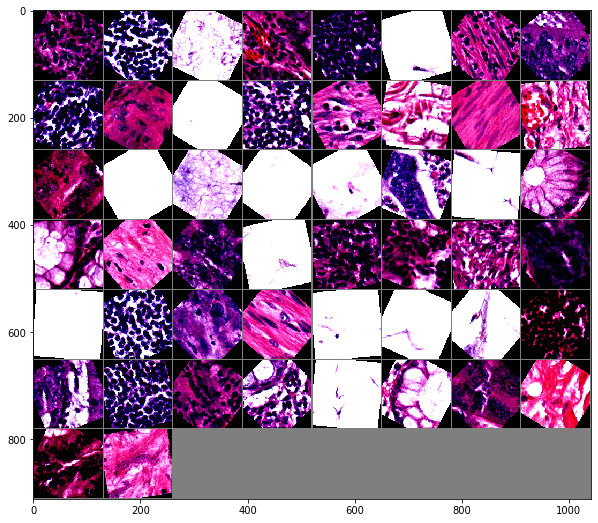

In [62]:
# NOTE: Code segment mostly from skin lesion classification project
# functions to show an image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

In [2]:
num_classes = 8
# We are using resnet34 trained on imagenet
net = torchvision.models.resnet34(pretrained = True)

# We replace last layer of resnet to match our number of classes which is 8
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\James/.cache\torch\checkpoints\resnet34-333f7ec4.pth


In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)

In [12]:
# NOTE: Code segment mostly from skin lesion classification project
from sklearn.metrics import accuracy_score

# Classes to do some evaluation during and post training
def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

In [13]:
# NOTE: Code segment mostly from skin lesion classification project
# number of loops over the dataset
num_epochs = 70
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    # Printout for clarity
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    # Saving data for post train evaluation
    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 1.507  Accuracy:0.477
Validation Loss: 0.975  Val Accuracy: 0.708
Epoch: 2
Loss: 0.548  Accuracy:0.810
Validation Loss: 0.404  Val Accuracy: 0.854
Epoch: 3
Loss: 0.336  Accuracy:0.880
Validation Loss: 0.330  Val Accuracy: 0.882
Epoch: 4
Loss: 0.268  Accuracy:0.911
Validation Loss: 0.280  Val Accuracy: 0.896
Epoch: 5
Loss: 0.243  Accuracy:0.917
Validation Loss: 0.294  Val Accuracy: 0.909
Epoch: 6
Loss: 0.222  Accuracy:0.920
Validation Loss: 0.254  Val Accuracy: 0.915
Epoch: 7
Loss: 0.189  Accuracy:0.934
Validation Loss: 0.302  Val Accuracy: 0.895
Epoch: 8
Loss: 0.183  Accuracy:0.937
Validation Loss: 0.236  Val Accuracy: 0.914
Epoch: 9
Loss: 0.164  Accuracy:0.944
Validation Loss: 0.195  Val Accuracy: 0.927
Epoch: 10
Loss: 0.153  Accuracy:0.948
Validation Loss: 0.236  Val Accuracy: 0.926
Epoch: 11
Loss: 0.137  Accuracy:0.950
Validation Loss: 0.240  Val Accuracy: 0.926
Epoch: 12
Loss: 0.136  Accuracy:0.952
Validation Loss: 0.282  Val Accuracy: 0.919
Epoch: 13
Loss: 0.114  Ac

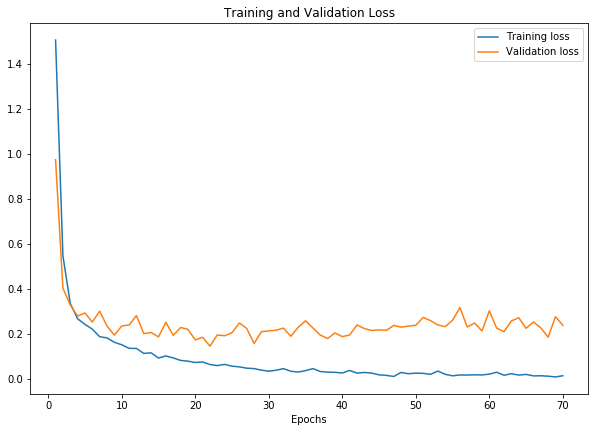

<Figure size 432x288 with 0 Axes>

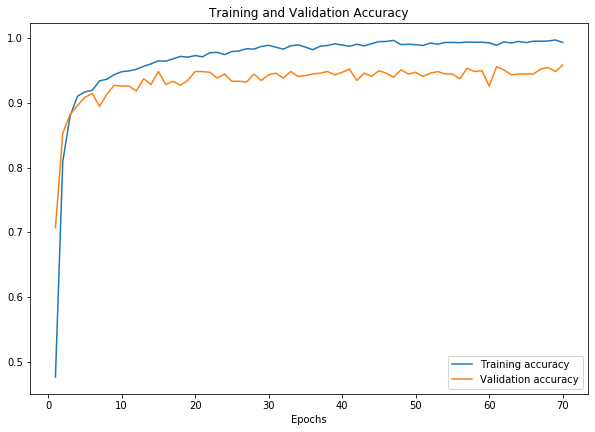

<Figure size 432x288 with 0 Axes>

In [14]:
# NOTE: Code segment mostly from skin lesion classification project
# We are plotting the loss and accuracy over the epochs
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

In [15]:
# NOTE: Code segment mostly from skin lesion classification project

# We simply go through all data in the testloader and evaluate how often correct predictions are made
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 94 %


In [64]:
# NOTE: Code segment mostly from skin lesion classification project

# The same as above is done, but evaluation is completed on a per class basis
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of tumor : 97 %
Accuracy of stroma : 82 %
Accuracy of complex : 85 %
Accuracy of lympho : 94 %
Accuracy of debris : 99 %
Accuracy of mucosa : 97 %
Accuracy of adipose : 93 %
Accuracy of empty : 99 %


# Segment Mapping Section
In this section we obtain a prediction mapping on the large 5000x5000 images

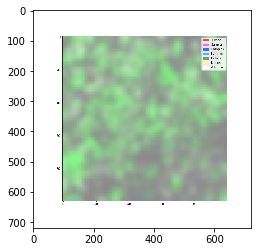

In [139]:
import glob
image_list = []
image_names = []
# Import the 10 large 5000x5000 pixel images to a list
for filename in glob.glob( source_large+ '/*.tif'):
    im=Image.open(filename)
    image_list.append(im)
    image_names.append(filename)

plt.imshow(image_list[1])

In [78]:
# This function splits the given image into non-overlapping height x width size pieces and returns in a list of lists
def segment(im, height, width):
    imgwidth, imgheight = im.size
    segments = []
    for i in range(0,imgheight,height):
        row = []
        for j in range(0,imgwidth,width):
            box = (j, i, j+width, i+height)
            row.append(im.crop(box).resize((128,128)))
        #Keep the image structure by adding rows
        segments.append(row)
    return segments
            
# Segment all images into 50x50 pieces and store in a list
seg_images = []
for img in image_list:
    seg_images.append(segment(img, 50, 50))


In [87]:
# This code goes through every 50x50 segment and returns what the prediction from resnet for that image is
guess_images = []
for img in seg_images:
    guess_image = []
    for row in img:
        guess_row = []
        for seg in row:
            # Convert PIL img to tensor
            images = transforms.ToTensor()(seg)
            images = images.to(device)
            outputs = net(images[None,...])
            # Get prediction
            _, predicted = torch.max(outputs.data, 1)
            # Add it to list
            guess_row.append(predicted)
        guess_image.append(guess_row)
    guess_images.append(guess_image)
            
# We end up with a list of 10 "images" in the form of 100x100 predictions for each 50x50 piece of that image

In [126]:
# Time to make those predictions into an actual image
from PIL import ImageFilter
# The classes and corresponding color for each class
classes = [ 'Tumor', 'Stroma', 'Complex', 'Lympho','Debris', 'Mucosa', 'Adipose', 'Empty']
colors = [(255, 69, 69) , (255, 99, 255), (65, 102, 250), (39, 201, 219),(138, 138, 138), (255, 250, 110), (255, 255, 255) , (125, 255, 127)]
segmaps = []
# For each prediction "image"
for img in guess_images:
    # Create a new 100x100 image
    segmap = Image.new('RGBA', (100, 100), "white")
    pixels = segmap.load()
    # Go through every pixel of the 100x100 image and change it to the corresponding class color
    for i in range(segmap.size[0]):    # for every col:
        for j in range(segmap.size[1]):    # For every row
            pixels[i,j] = colors[img[i][j]]
    # A Gaussian blur is added to smooth out error
    segmaps.append(segmap.filter(ImageFilter.GaussianBlur(radius=2)))

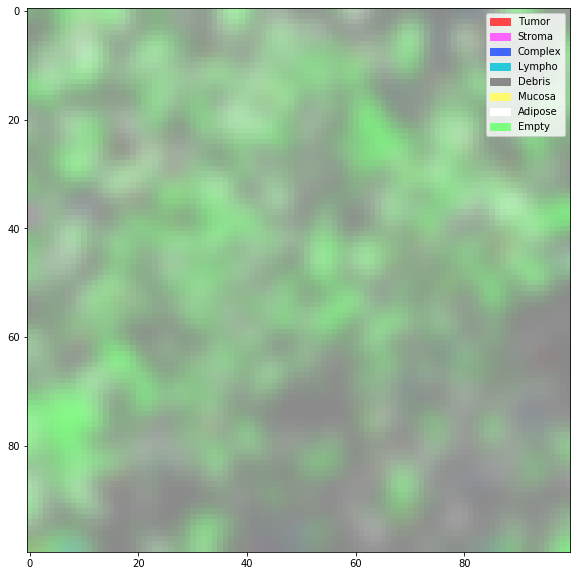

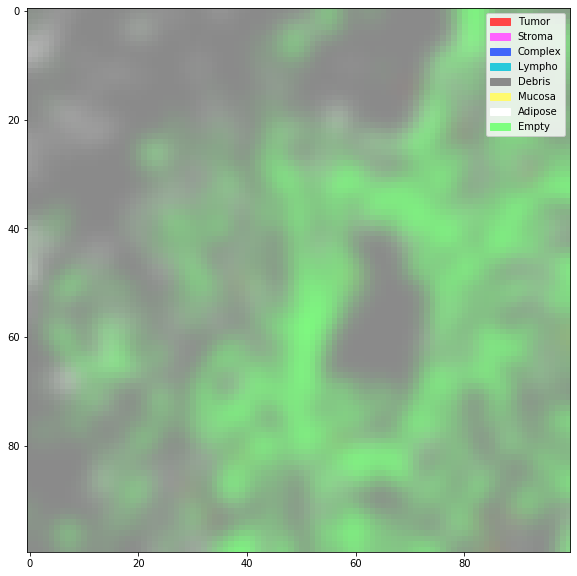

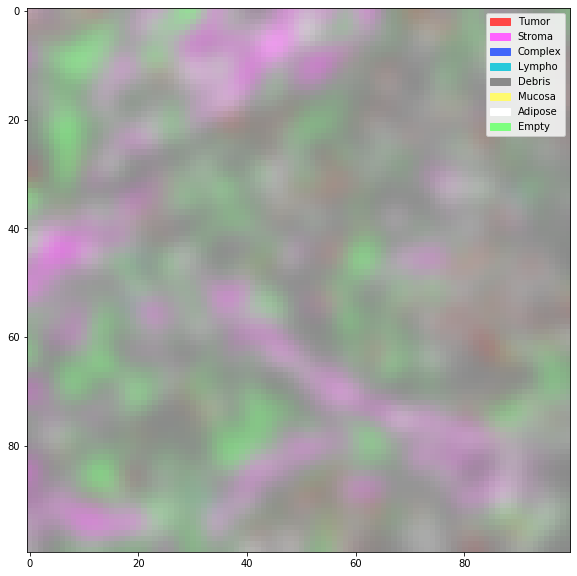

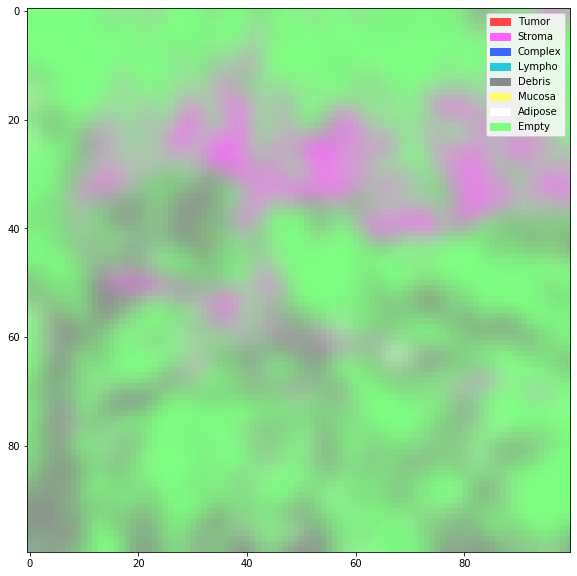

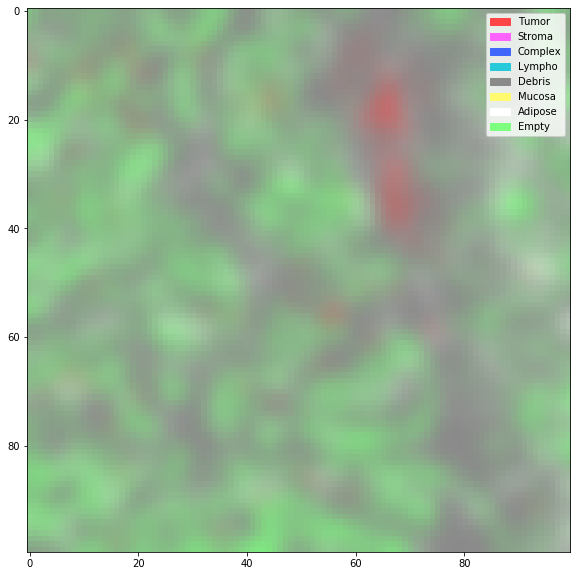

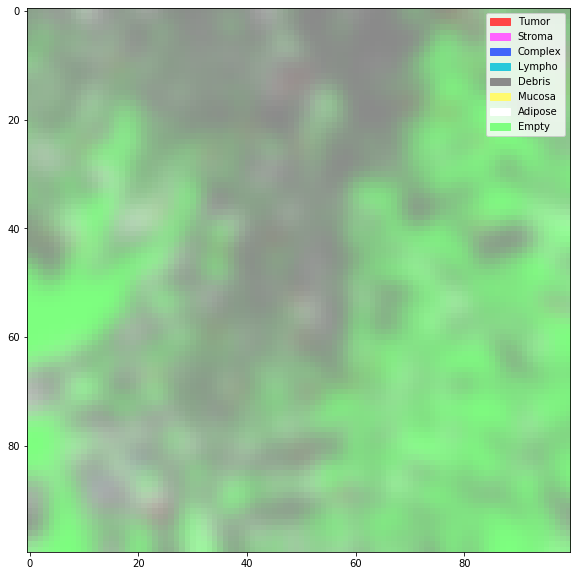

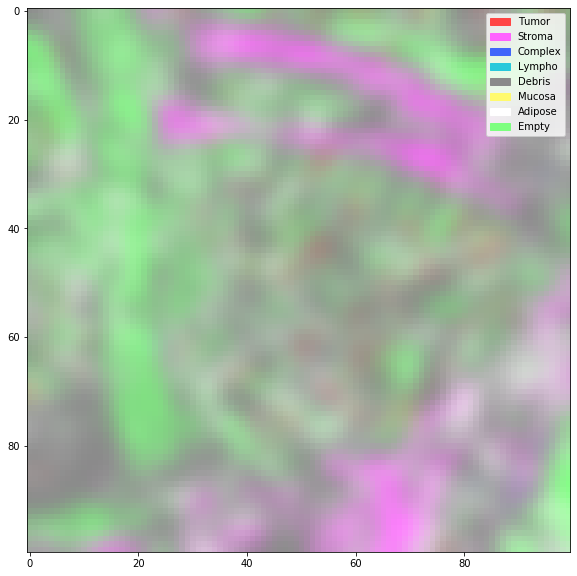

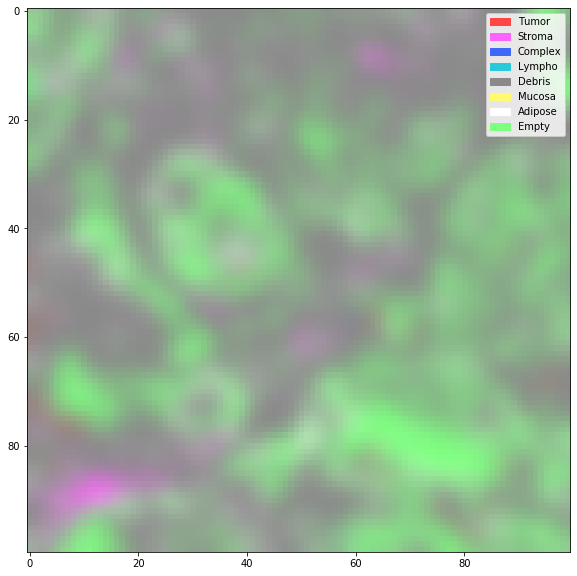

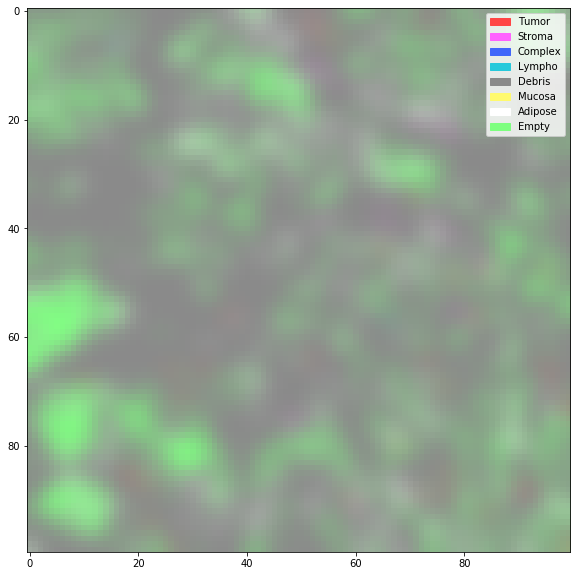

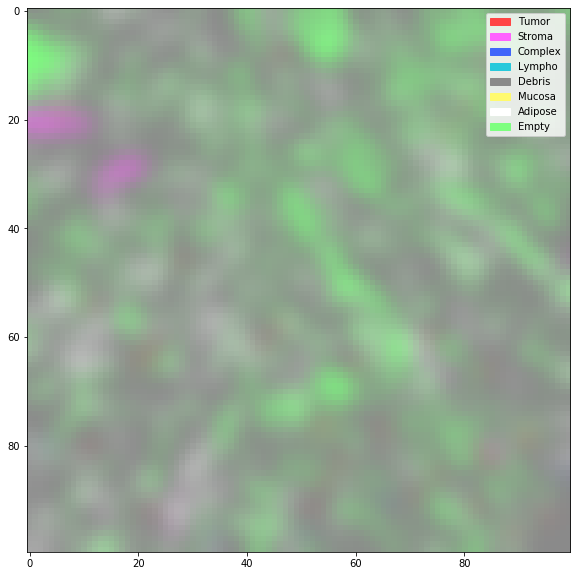

In [140]:
import matplotlib.patches as mpatches
patches = []
# Setting up patches for legends
for i in range(0,8):
    patchColor = ((colors[i][0])/255, (colors[i][1])/255, (colors[i][2])/255)
    patches.append(mpatches.Patch(color=patchColor, label=classes[i]))

# Displaying the prediction mappings and saving them 
for i in range(len(segmaps)):
    plt.figure(figsize=(10,10))
    plt.legend(handles=patches)
    plt.imshow(segmaps[i])
    plt.savefig(image_names[i][:-5]+"_SEGMAP.tif")